# 取得したデータを使って解析してみる

## 巻ごとに収録されている話数

In [46]:
import pandas as pd

df_volume = pd.read_csv("./dataset_csv/Volume-Index-Case-Title.csv", encoding="utf-8")
df_volume.groupby("volume").agg({"index": "count"}).reset_index()

,volume,index
0,1,9
1,2,10
2,3,10
3,4,10
4,5,11
...,...,...
102,103,8
103,104,11
104,105,10
105,106,10


(array([ 1.,  1., 32., 73.]),
 array([ 8.,  9., 10., 11., 12.]),
 <BarContainer object of 4 artists>)

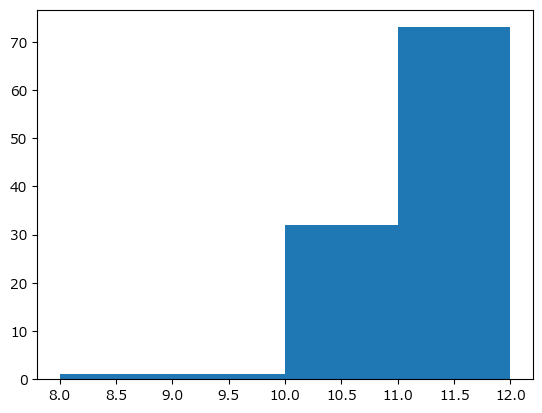

In [47]:
import matplotlib.pyplot as plt

plt.hist(df_volume.groupby("volume").agg({"index": "count"}).reset_index()["index"],bins=4)

## メインキャラクターの登場回数

In [49]:
df_main_character = pd.read_csv("./dataset_csv/Title-MainCharacter.csv", encoding="utf-8")
df_main_character.groupby("mchara").agg({"case": "count"}).reset_index().sort_values("case", ascending=False)

,mchara,case
44,江戸川コナン,326
42,毛利蘭,236
41,毛利小五郎,188
50,目暮十三,146
48,灰原哀,142
...,...,...
17,伊達航,4
55,諸伏景光,4
45,沖田総司,4
54,萩原研二,4


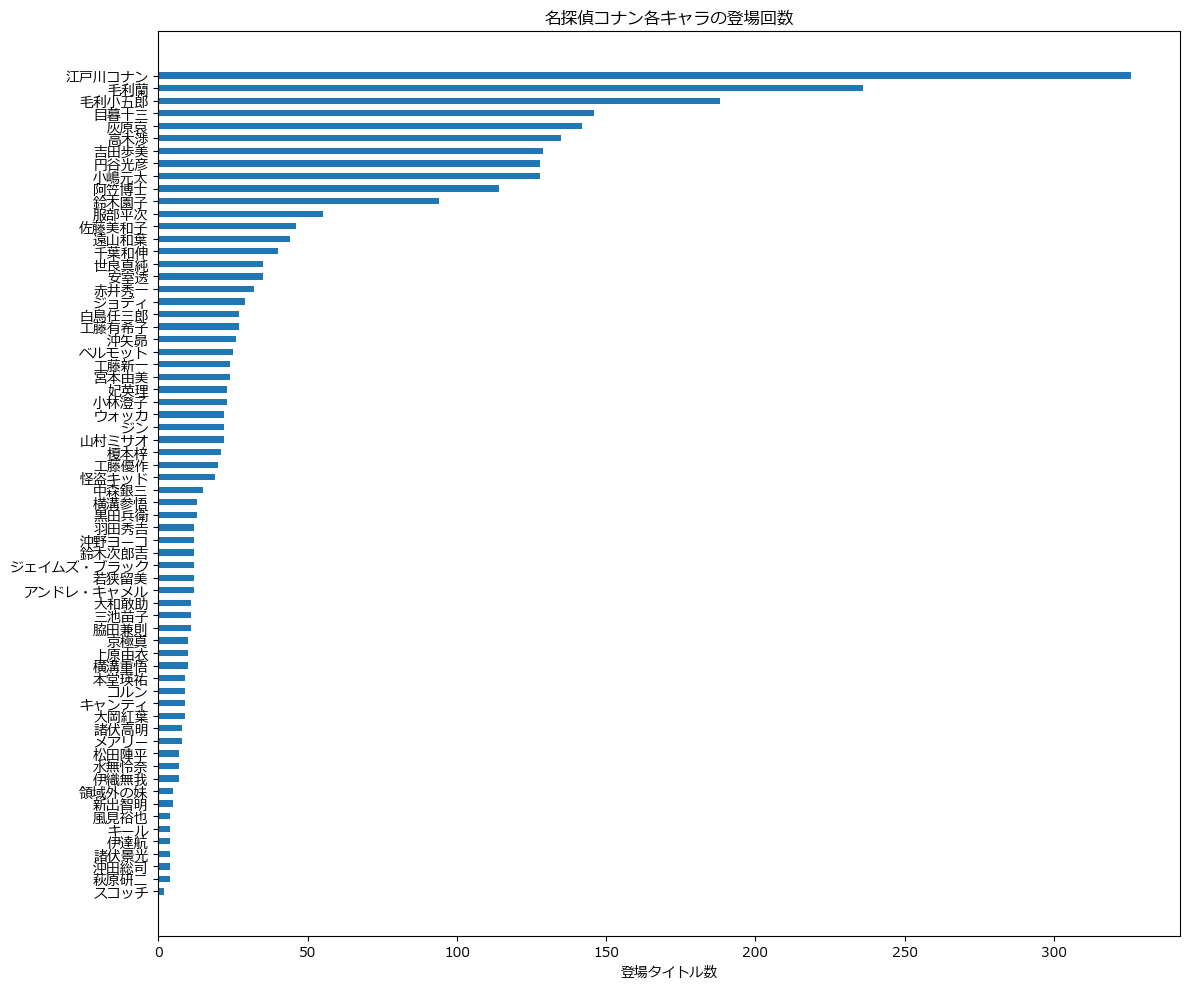

In [50]:
char_counts = df_main_character.groupby("mchara").agg({"case": "count"}).reset_index()
char_counts = char_counts.rename(columns={"case": "count"})
char_counts = char_counts.sort_values("count", ascending=False)

# ▶ y位置に余白をつけて手動で調整
y_pos = [i * 2.0 for i in range(len(char_counts))]  # 1.3倍にすると間が空く

# プロット
plt.figure(figsize=(12, 10))
plt.barh(y_pos, char_counts["count"], height=1.0)  # heightは1.0のままでOK
plt.yticks(y_pos, char_counts["mchara"])
plt.xlabel("登場タイトル数")
plt.title("名探偵コナン各キャラの登場回数")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 各タイトルに登場したメインキャラクターの数

                              case  character_count
67                     マリアちゃんをさがせ！               27
122          太閤名人の将棋盤［初手編／妙手編／王手編］               21
260                         紅の修学旅行               20
31                    キッドＶＳ高明狙われた唇               19
217               標的（ターゲット）は警視庁交通部               19
311                       骨董盆は隠せない               19
266               緋色シリーズ［交錯／帰還／真相］               18
281         赤と黒のクラッシュ[嫌疑／潔白／決死／殉職]               18
237  漆黒の特急[ミステリートレイン][発車／隧道／交差／終点]               18
112                       大岡紅葉の挑戦状               18
318              黒ずくめの謀略［狩り／上陸／正体］               18
250                          白い手の女               16
1                          17年前の真相               16
184                揺れる警視庁1200万人の人質               16
102      命を賭けた恋愛中継[中継開始／絶体絶命／現場突入]               15
277                         謎めいた乗客               15
61             ブラックインパクト！組織の手が届く瞬間               15
309                        騎士は見ていた               14
152         

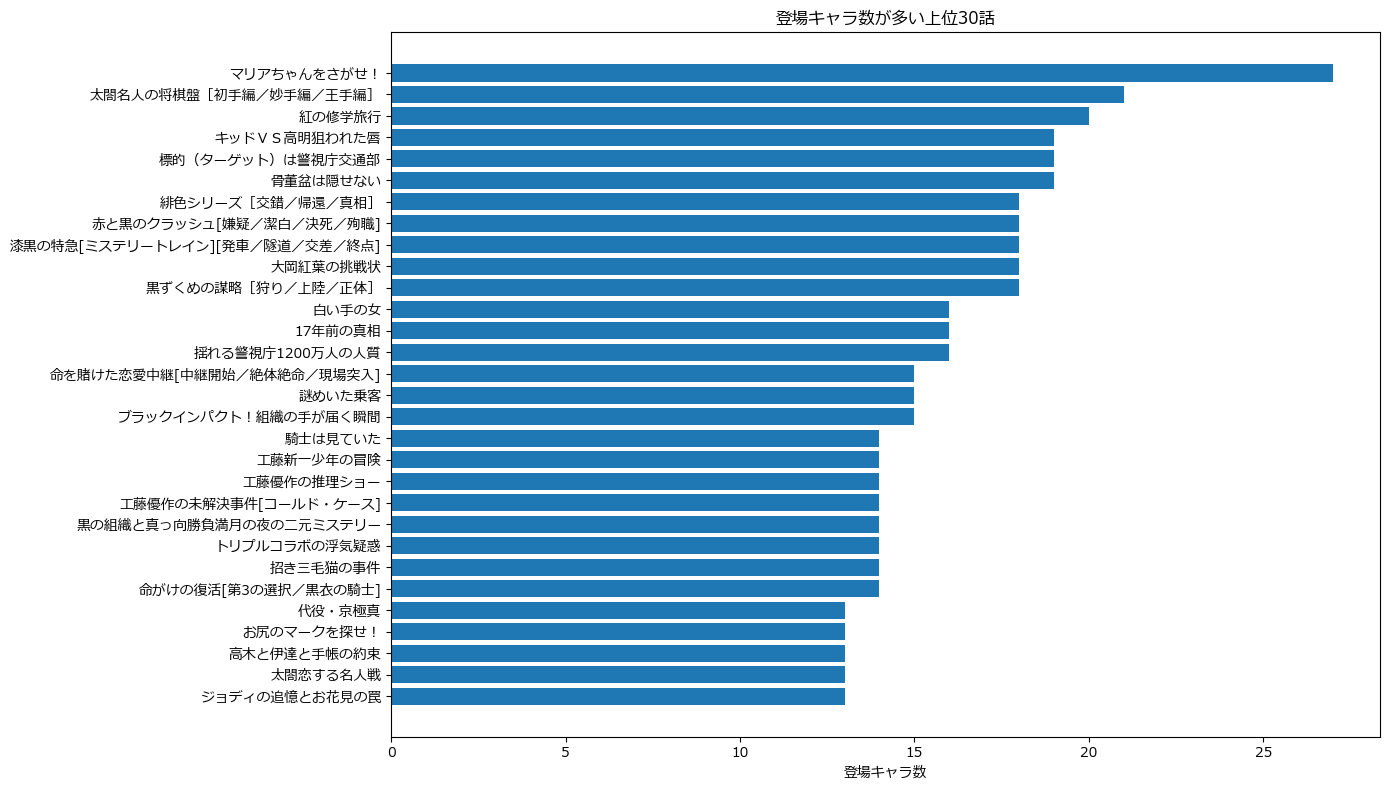

In [52]:
character_counts_per_title = df_main_character.groupby("case")["mchara"].nunique().reset_index()
character_counts_per_title = character_counts_per_title.rename(columns={"mchara": "character_count"})

# 登場キャラ数でソートして上位30件を抽出
# キャラクターが多いほど重要回である可能性が高い
top30 = character_counts_per_title.sort_values("character_count", ascending=False).head(30)

# 表示確認（任意）
print(top30)

# 棒グラフ描画
plt.figure(figsize=(14, 8))
plt.barh(top30["case"], top30["character_count"])
plt.xlabel("登場キャラ数")
plt.title("登場キャラ数が多い上位30話")
plt.gca().invert_yaxis()  # キャラ数が多いものを上に
plt.tight_layout()
plt.show()

(array([78., 87., 96., 36., 14.,  6.,  8.,  2.,  0.,  1.]),
 array([ 3. ,  5.4,  7.8, 10.2, 12.6, 15. , 17.4, 19.8, 22.2, 24.6, 27. ]),
 <BarContainer object of 10 artists>)

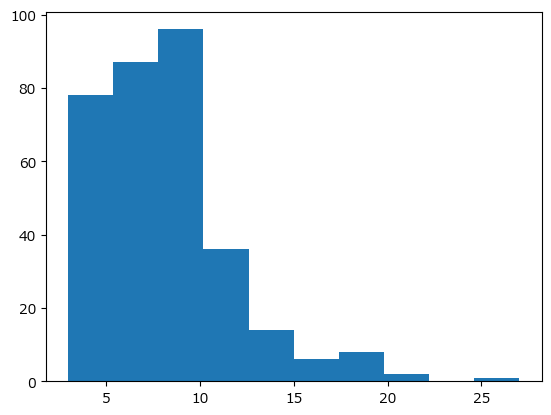

In [ ]:
plt.hist(character_counts_per_title["character_count"])

## キャラクターを特徴量化/マッピング

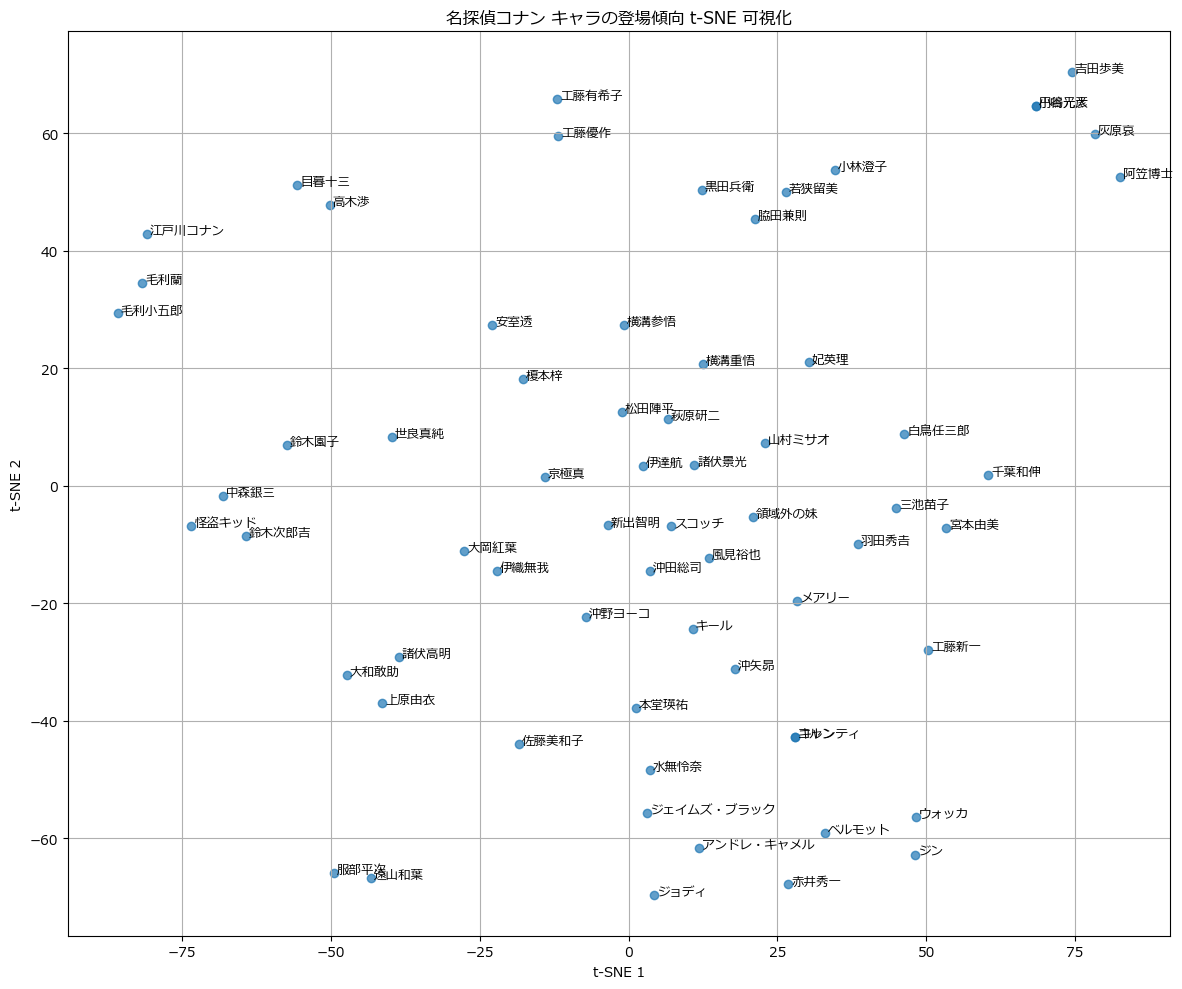

In [53]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

# CSV読み込み
df = pd.read_csv("./dataset_csv/Title-MainCharacter.csv", encoding="utf-8")

# 話数ごとに登場キャラをまとめる（逆転してキャラ × 話数 の行列をつくる）
df["appear"] = 1
pivot = df.pivot_table(index="mchara", columns="case", values="appear", fill_value=0)

# t-SNEで2次元に次元削減
tsne = TSNE(n_components=2, random_state=42, perplexity=10)  # perplexityは調整可
tsne_result = tsne.fit_transform(pivot)

# 結果をDataFrameにまとめる
tsne_df = pd.DataFrame(tsne_result, columns=["x", "y"])
tsne_df["mchara"] = pivot.index

# 可視化
plt.figure(figsize=(12, 10))
plt.scatter(tsne_df["x"], tsne_df["y"], alpha=0.7)

# 各点にラベルをつける（重なり注意）
for _, row in tsne_df.iterrows():
    plt.text(row["x"] + 0.5, row["y"], row["mchara"], fontsize=9)

plt.title("名探偵コナン キャラの登場傾向 t-SNE 可視化")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\lisa1\anaconda3\envs\conan\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


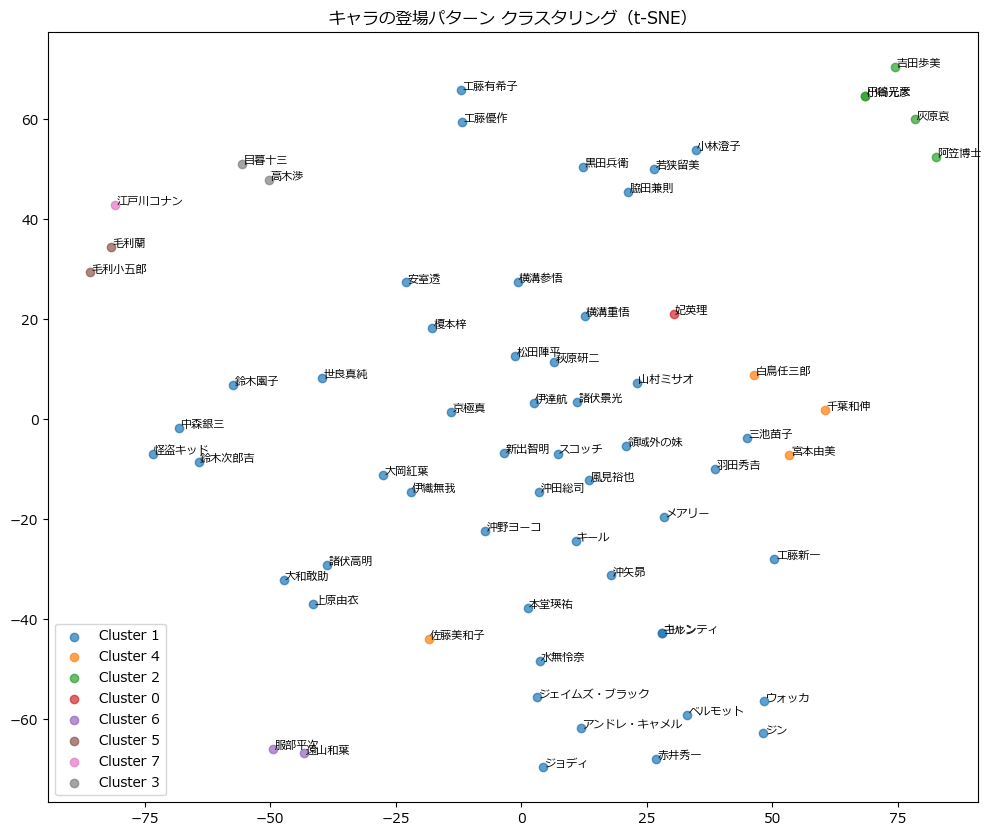

In [54]:
# クラスタ分析の場合

from sklearn.cluster import KMeans

# 5クラスタに分ける（適宜調整）
kmeans = KMeans(n_clusters=8, random_state=42)
tsne_df["cluster"] = kmeans.fit_predict(pivot)

# 色分け表示
plt.figure(figsize=(12, 10))
for c in tsne_df["cluster"].unique():
    subset = tsne_df[tsne_df["cluster"] == c]
    plt.scatter(subset["x"], subset["y"], label=f"Cluster {c}", alpha=0.7)
    for _, row in subset.iterrows():
        plt.text(row["x"] + 0.3, row["y"], row["mchara"], fontsize=8)
plt.legend()
plt.title("キャラの登場パターン クラスタリング（t-SNE）")
plt.show()

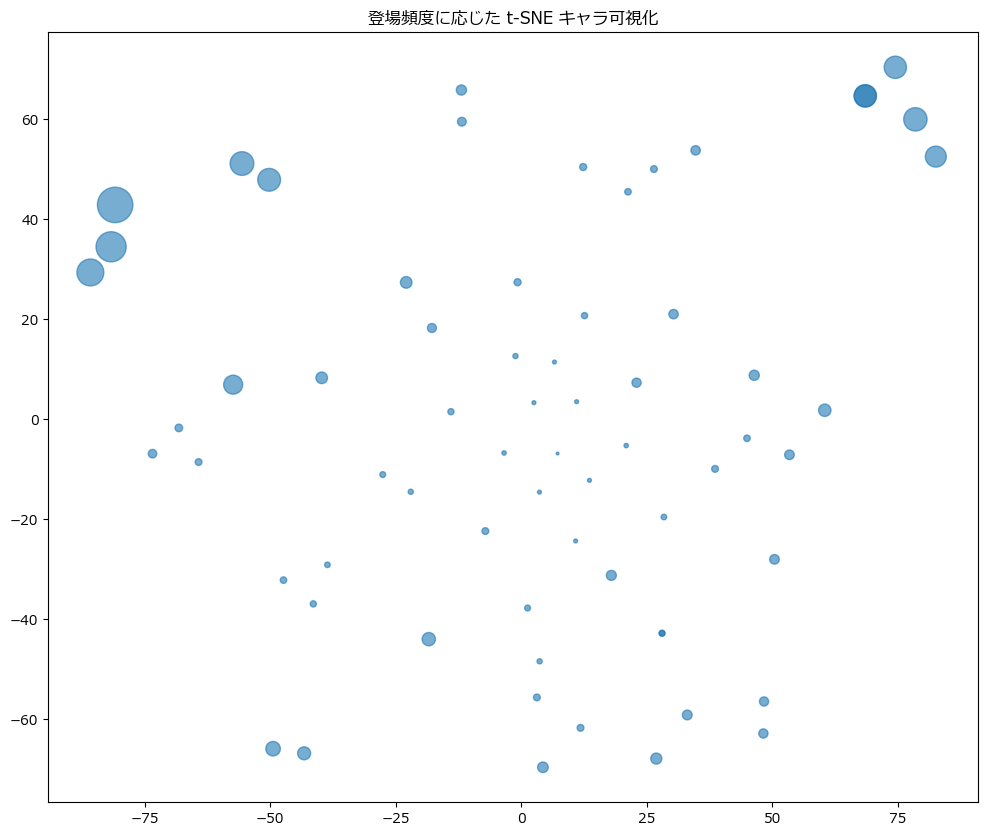

In [55]:
# 登場話数の情報を元にサイズ指定
appear_count = df["mchara"].value_counts()
tsne_df["size"] = tsne_df["mchara"].map(appear_count)

plt.figure(figsize=(12, 10))
plt.scatter(tsne_df["x"], tsne_df["y"], s=tsne_df["size"] * 2, alpha=0.6)
plt.title("登場頻度に応じた t-SNE キャラ可視化")
plt.show()

## 共演パターン分析

In [57]:
import pandas as pd
from itertools import combinations
from collections import Counter

# データ読み込み
df = pd.read_csv("./dataset_csv/Title-MainCharacter.csv", encoding="utf-8")

# 共演ペアのカウント
pair_counter = Counter()

# 各話ごとにキャラを抽出し、組み合わせをカウント
for title, group in df.groupby("case"):
    chars = group["mchara"].unique()
    for pair in combinations(sorted(chars), 2):  # 辞書順で組み合わせ（重複なし）
        pair_counter[pair] += 1

# 結果をDataFrameに
coappear_df = pd.DataFrame([
    {"char1": k[0], "char2": k[1], "count": v} for k, v in pair_counter.items()
])

# 共演回数の多い順に表示
coappear_df = coappear_df.sort_values("count", ascending=False)
print(coappear_df.head(20))


      char1   char2  count
204     毛利蘭  江戸川コナン    234
198   毛利小五郎  江戸川コナン    188
197   毛利小五郎     毛利蘭    182
26   江戸川コナン    目暮十三    145
25   江戸川コナン     灰原哀    142
29   江戸川コナン     高木渉    135
112    吉田歩美  江戸川コナン    129
100    円谷光彦    小嶋元太    128
99     円谷光彦    吉田歩美    128
102    円谷光彦  江戸川コナン    128
110    吉田歩美    小嶋元太    128
121    小嶋元太  江戸川コナン    128
122    小嶋元太     灰原哀    117
103    円谷光彦     灰原哀    117
113    吉田歩美     灰原哀    117
28   江戸川コナン    阿笠博士    114
41     目暮十三     高木渉    111
230     毛利蘭    目暮十三    106
37      灰原哀    阿笠博士     99
212  江戸川コナン    鈴木園子     94


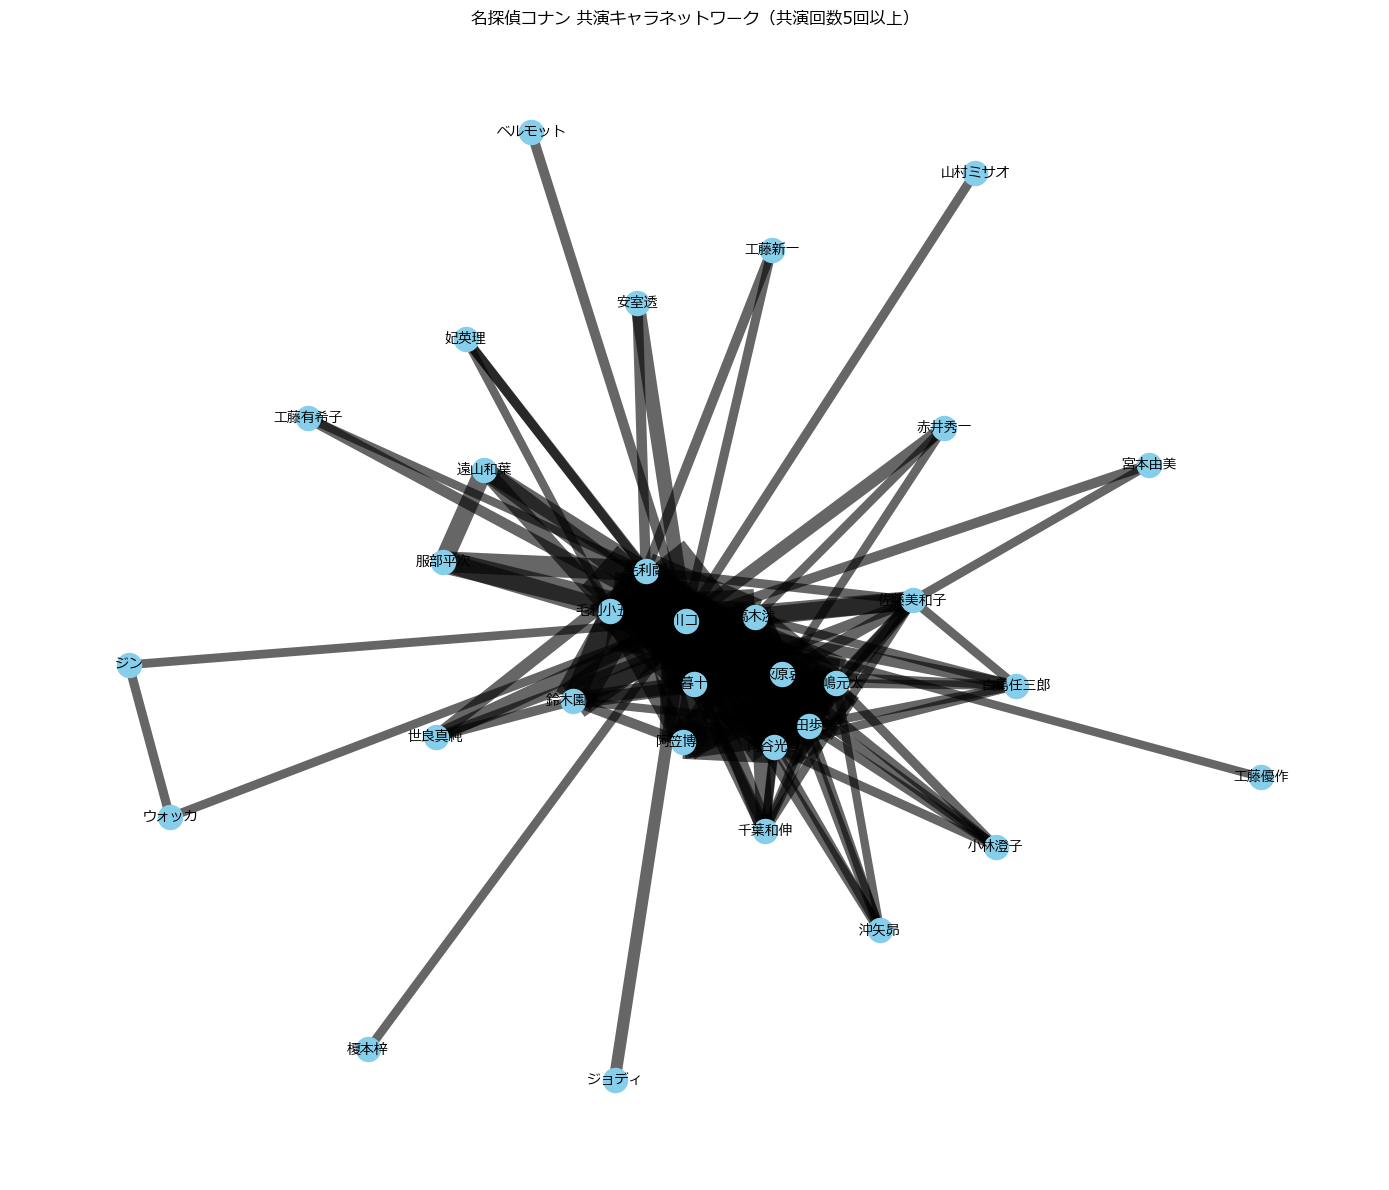

In [58]:
import networkx as nx
import matplotlib.pyplot as plt

# グラフ構築（共演回数が一定以上のペアだけ使う）
G = nx.Graph()
for _, row in coappear_df[coappear_df["count"] >= 20].iterrows():  # 例：5回以上共演
    G.add_edge(row["char1"], row["char2"], weight=row["count"])

# レイアウトと描画
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)  # 力学レイアウト
edges = G.edges(data=True)

# 線の太さを共演回数に応じて変える
weights = [d["weight"] for (u, v, d) in edges]
nx.draw_networkx_edges(G, pos, width=[w * 0.3 for w in weights], alpha=0.6)
nx.draw_networkx_nodes(G, pos, node_size=300, node_color="skyblue")
nx.draw_networkx_labels(G, pos, font_family="Meiryo", font_size=10)

plt.title("名探偵コナン 共演キャラネットワーク（共演回数5回以上）")
plt.axis("off")
plt.tight_layout()
plt.show()


## ストーリーアークごとの分析

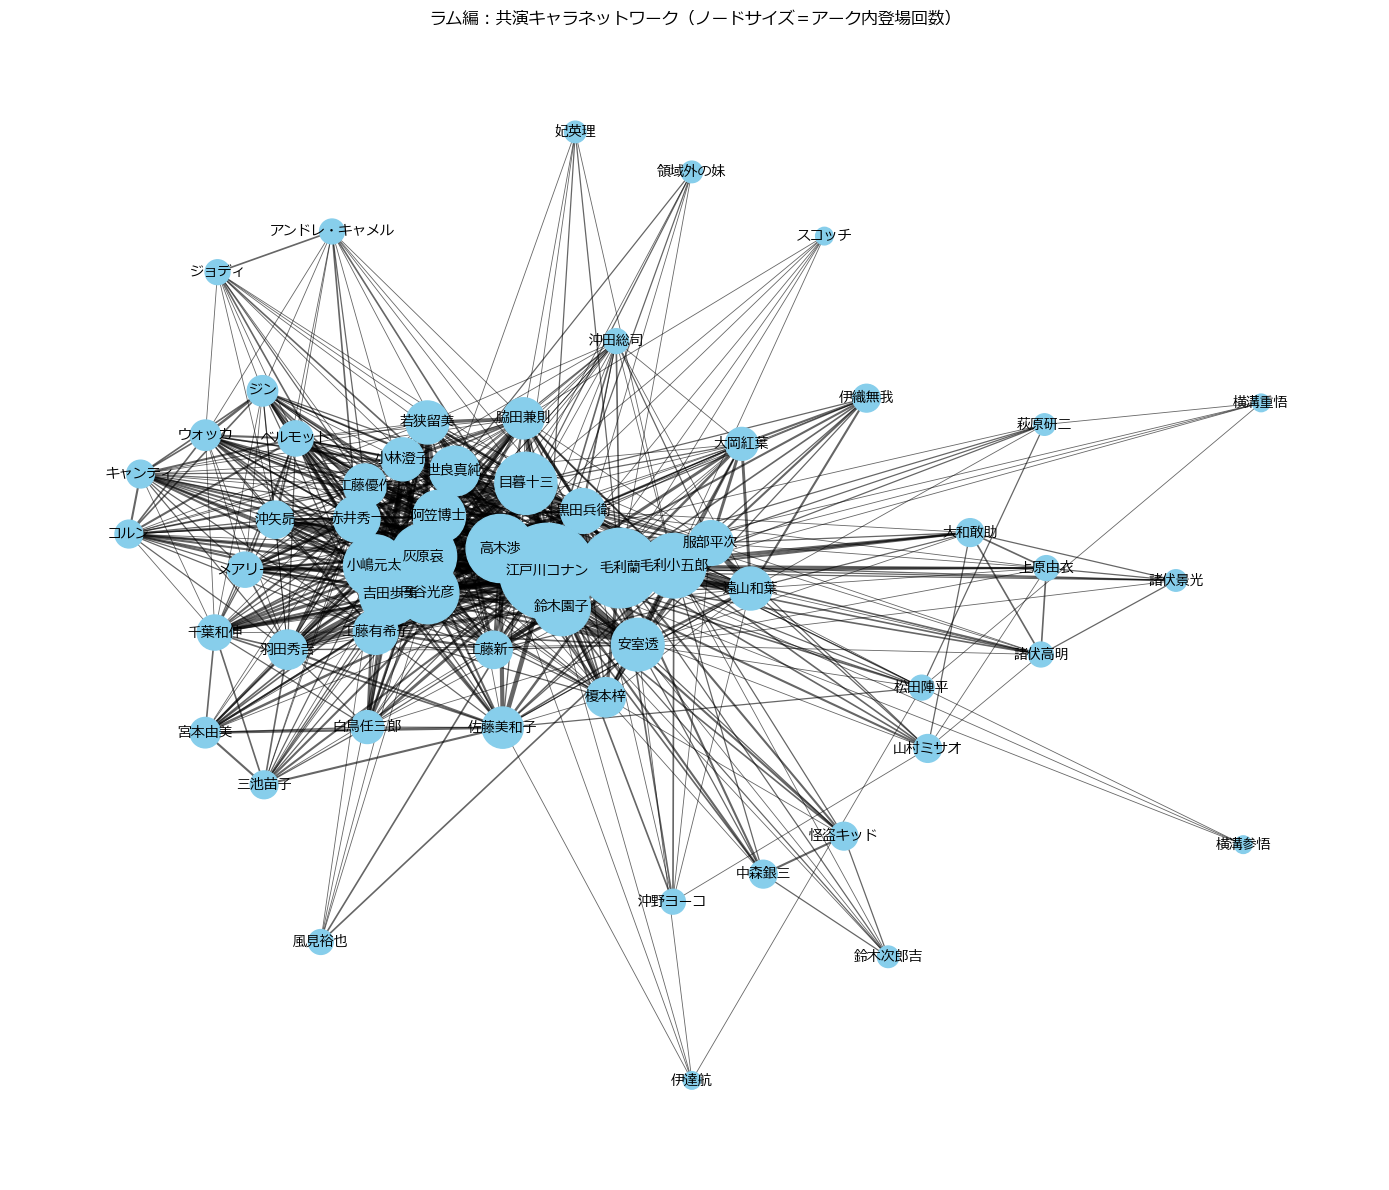

In [105]:
import pandas as pd
from itertools import combinations
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt

# CSV読み込み
df_char = pd.read_csv("./dataset_csv/Title-MainCharacter.csv", encoding="utf-8")
df_case = pd.read_csv("./dataset_csv/Volume-Index-Case-Title.csv", encoding="utf-8")

# アークを巻数から割り振る
def assign_arc(volume):
    if volume <= 19: return "シェリー編"
    elif volume <= 42: return "ベルモット編"
    elif volume <= 67: return "キール編"
    elif volume <= 85: return "バーボン編"
    elif volume <= 104: return "ラム編"
    else: return "???編"

df_case["arc"] = df_case["volume"].apply(assign_arc)

# titleでマージしてアーク情報を付加
df_merged = pd.merge(df_char, df_case[["case", "arc"]], on="case", how="left")

# ----------------------------
# 🔁 アークごとにネットワークを描画
# ----------------------------
target_arc = "ラム編"  # ← 任意のアーク名に変更可能

# アーク内のみ抽出
arc_df = df_merged[df_merged["arc"] == target_arc]

# キャラごとの登場回数（アーク内のみ）
appear_count_arc = arc_df.groupby("mchara")["case"].nunique()

# 共演ペアのカウント
pair_counter = Counter()
for title, group in arc_df.groupby("case"):
    chars = group["mchara"].unique()
    for pair in combinations(sorted(chars), 2):
        pair_counter[pair] += 1

# NetworkXグラフ構築
G = nx.Graph()
for (char1, char2), count in pair_counter.items():
    if count >= 2:  # 共演3回以上のみ描画
        G.add_edge(char1, char2, weight=count)

# ノードサイズをアーク内登場回数に応じて反映
node_sizes = [appear_count_arc.get(node, 1) * 80 for node in G.nodes()]

# 描画
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G, seed=42)
edges = G.edges(data=True)
weights = [d["weight"] for (_, _, d) in edges]

nx.draw_networkx_edges(G, pos, width=[w * 0.3 for w in weights], alpha=0.6)
nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=node_sizes)
nx.draw_networkx_labels(G, pos, font_family="Meiryo", font_size=10)

plt.title(f"{target_arc}：共演キャラネットワーク（ノードサイズ＝アーク内登場回数）")
plt.axis("off")
plt.tight_layout()
plt.show()


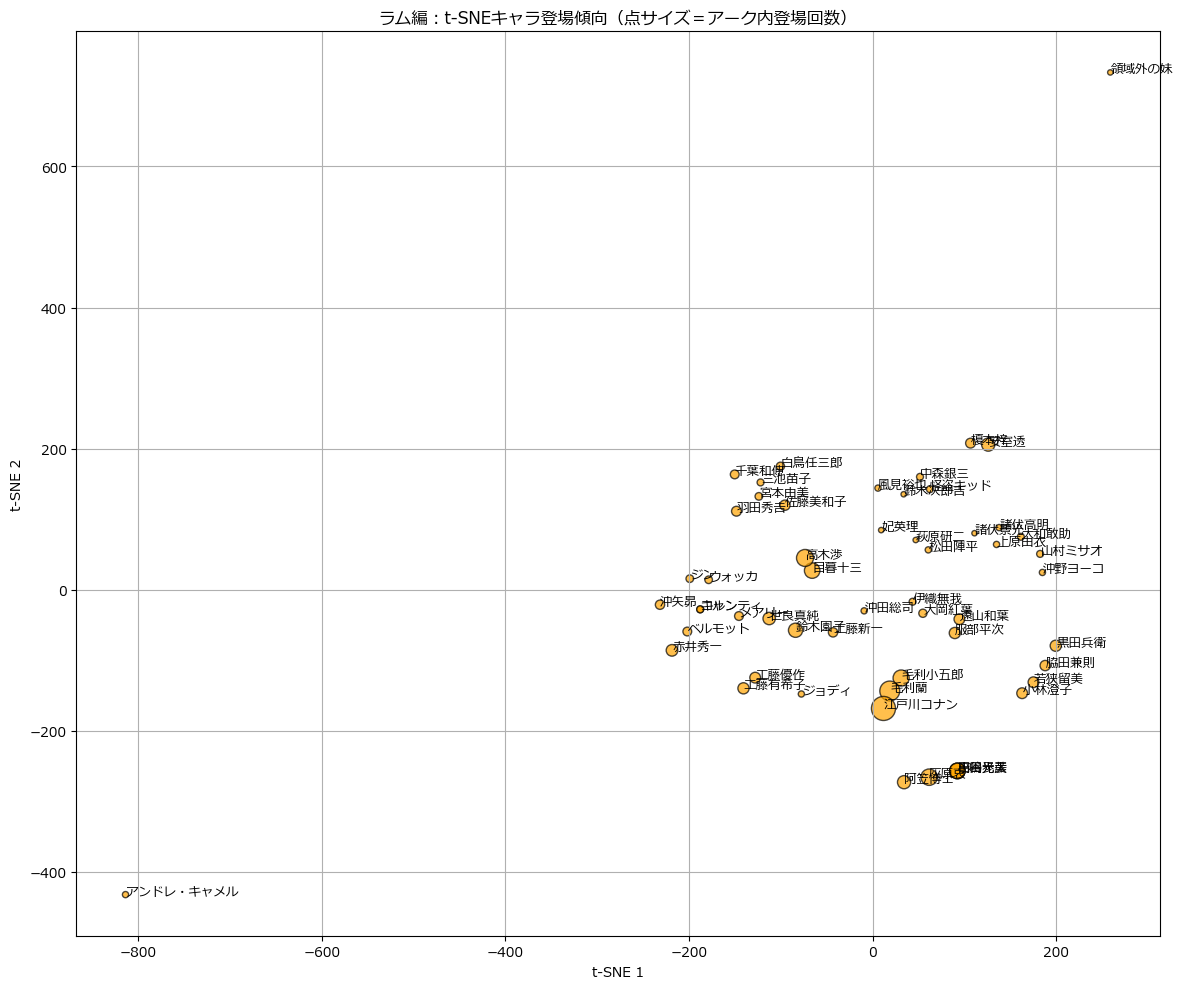

In [106]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# アークを指定
target_arc = "ラム編"
arc_df = df_merged[df_merged["arc"] == target_arc].copy()

# キャラ×話数の出現マトリクスを作成
arc_df["appear"] = 1
pivot = arc_df.pivot_table(index="mchara", columns="case", values="appear", fill_value=0)

# 少数キャラ除外（任意）
pivot = pivot[pivot.sum(axis=1) > 2]

# アーク内の登場回数を取得（キャラごとに）
appear_count_arc = pivot.sum(axis=1)

# t-SNE実行
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
tsne_result = tsne.fit_transform(pivot)

# t-SNE結果をDataFrameにまとめる
tsne_df = pd.DataFrame(tsne_result, columns=["x", "y"])
tsne_df["mchara"] = pivot.index
tsne_df["appear_count_arc"] = tsne_df["mchara"].map(appear_count_arc)  # ★ここが重要

# 描画（サイズ = アーク内登場回数 × 5）
plt.figure(figsize=(12, 10))
plt.scatter(
    tsne_df["x"], tsne_df["y"],
    s=tsne_df["appear_count_arc"] * 5,
    alpha=0.7, c="orange", edgecolor="k"
)

# ラベル（登場数が多いキャラのみ）
for _, row in tsne_df.iterrows():
    #if row["appear_count_arc"] > 3:
    plt.text(row["x"] + 0.3, row["y"], row["mchara"], fontsize=9)

plt.title(f"{target_arc}：t-SNEキャラ登場傾向（点サイズ＝アーク内登場回数）")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()
